**Másteres Universitarios en Ciencia de Datos, Ingeniería Informática, e Innovación en Inteligencia Computacional y Sistemas Interactivos, UAM**
## **Procesamiento del Lenguaje Natural**
# **Práctica de laboratorio 3: Análisis de sentimientos mediante redes neuronales**

---



# ***Ejercicio 1 - FFNs***

# Carga y preprocesado de datos - One-hot encoding

In [4]:
# Montamos el drive
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
# Fijamos semillas para generación de números aleatorios
import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(2)

In [6]:
import re
import pandas as pd

# Utilizamos el Stanford Sentiment Treebank (SST) como corpus de prueba para análisis de sentimientos de textos
# Cargamos y procesamos los datos para tratarlos como un problema de clasificación binaria de sentimientos
# Convertimos la escala de sentimientos de [1,5] a {0,1}
def load_sst_dataset(file_path, label_map={0:0, 1:0, 2:None, 3:1, 4:1}):
    data = []
    with open(file_path) as f:
        for i, line in enumerate(f):
            instance = {}
            instance['label'] = label_map[int(line[1])]
            if instance['label'] is None:
                continue

            # Filtramos caracteres y etiquetas de parseo
            text = re.sub(r'\s*(\(\d)|(\))\s*', '', line)
            instance['text'] = text[1:]
            data.append(instance)
    data = pd.DataFrame(data)
    return data

data_folder = 'C:/Users/Xudon/Documents/GitHub/NLP/Lab_3/nlp2425-lab3_data/data/'
training_set = load_sst_dataset(data_folder + 'sst_training.txt') # conjunto de datos de entrenamiento
validation_set = load_sst_dataset(data_folder + 'sst_validation.txt') # conjunto de datos de validación
test_set = load_sst_dataset(data_folder + 'sst_test.txt') # conjunto de datos de test

print('Instancias de entrenamiento: {}'.format(len(training_set)))
print('Instancias de de validación: {}'.format(len(validation_set)))
print('Instancias de de test: {}'.format(len(test_set)))

Instancias de entrenamiento: 6920
Instancias de de validación: 872
Instancias de de test: 1821


In [7]:
from tensorflow.keras.preprocessing import text
from sklearn.utils import shuffle

# Desordenamos los conjuntos de datos
training_set = shuffle(training_set)
validation_set = shuffle(validation_set)
test_set = shuffle(test_set)

# Separamos textos y etiquetas de los conjuntos de datos
training_texts = training_set.text
training_labels = training_set.label
validation_texts = validation_set.text
validation_labels = validation_set.label
test_texts = test_set.text
test_labels = test_set.label

# Construimos un índice (vocabulario) para las 1000 palabras más frecuentes en el conjunto de datos de entrenamiento
tokenizer = text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(training_texts)

print("10 palabras del vocabulario con mayor frecuencia:")
words_index = tokenizer.word_index
for word, index in list(words_index.items())[:10]:
    count = tokenizer.word_counts[word]
    print(f"\t{word}  (índice: {index}, frecuencia: {count})")
print()

sorted_word_counts = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=False)
last_words_counts = sorted_word_counts[:10]
print("10 palabras del vocabulario con menor frecuencia:")
for word, count in last_words_counts:
    index = tokenizer.word_index[word]
    print(f"\t{word}  (índice: {index}, frecuencia: {count})")

10 palabras del vocabulario con mayor frecuencia:
	the  (índice: 1, frecuencia: 5996)
	a  (índice: 2, frecuencia: 4385)
	and  (índice: 3, frecuencia: 3869)
	of  (índice: 4, frecuencia: 3680)
	to  (índice: 5, frecuencia: 2464)
	is  (índice: 6, frecuencia: 2099)
	's  (índice: 7, frecuencia: 2025)
	it  (índice: 8, frecuencia: 1952)
	that  (índice: 9, frecuencia: 1613)
	in  (índice: 10, frecuencia: 1581)

10 palabras del vocabulario con menor frecuencia:
	aid  (índice: 7198, frecuencia: 1)
	milking  (índice: 7199, frecuencia: 1)
	ken  (índice: 7200, frecuencia: 1)
	vacuous  (índice: 7201, frecuencia: 1)
	embody  (índice: 7202, frecuencia: 1)
	nouvelle  (índice: 7203, frecuencia: 1)
	enact  (índice: 7204, frecuencia: 1)
	chapter  (índice: 7205, frecuencia: 1)
	playwright  (índice: 7206, frecuencia: 1)
	drinker  (índice: 7207, frecuencia: 1)


In [8]:
# Vectorizamos los textos mediante la representación one-hot encoding
x_training = tokenizer.texts_to_matrix(training_texts, mode='binary')
y_training = training_labels
x_validation = tokenizer.texts_to_matrix(validation_texts, mode='binary')
y_validation = validation_labels
x_test = tokenizer.texts_to_matrix(test_texts, mode='binary')
y_test = test_labels

print('Dimensiones del conjunto de entrenamiento: {}'.format(x_training.shape))
print('Dimensiones del conjunto de validación: {}'.format(x_validation.shape))
print('Dimensiones del conjunto de test: {}'.format(x_test.shape))

Dimensiones del conjunto de entrenamiento: (6920, 1000)
Dimensiones del conjunto de validación: (872, 1000)
Dimensiones del conjunto de test: (1821, 1000)


In [9]:
# Comprobación de algunos vectores generados:
# Iteramos sobre n textos (de entrenamiento) y sus vectores correspondientes
n = 3

index_to_word = tokenizer.index_word # Mapeos de índices a palabras en el vocabulario
word_counts = tokenizer.word_counts # Frecuencias de las palabras en los textos

for i, (text, text_vector) in enumerate(zip(training_texts[:n], x_training[:n]), start=1):
    print(f"Texto {i}: {text}")
    print(f"Vector: {text_vector}")
    print("Palabras:")
    for index, value in enumerate(text_vector):
        # Si el valor en el vector es 1, obtenemos la palabra correspondiente, junto con su índice y frecuencia en el vocabulario
        if value == 1:
            word = index_to_word.get(index)
            word_frequency = word_counts.get(word, 0) if word else 0
            print(f"\t{word} (índice={index}, frecuencia={word_frequency})")
    print()

Texto 1: It is dark , brooding and slow , and takes its central idea way too seriously .
Vector: [0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.

# Construcción de la red

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

input_size = x_training[0].shape[0] # la longitud del vector de entrada es igual al tamaño del vocabulario

# Definimos una red neuronal feedforward con una única capa oculta de 16 unidades
# y ReLU como función de activación
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=(input_size,))) # Nota: no es necesario indicar input_shape en capas sucesivas
model.add(Dense(units=1, activation='sigmoid'))

# Compilamos la red usando la entropía cruzada binaria como función de pérdida,
# el algoritmo Adam como optimizador del descenso por gradiente,
# y accuracy como métrica de evaluación en entrenamiento y validación
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Opcionalmente se pueden utilizar otras funciones de activación (e.g., tanh, sigmoid) en vez de ReLU
# y otras funciones de pérdida como mean squared error (MSE)

c:\Users\Xudon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │        16,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,033 (62.63 KB)

 Trainable params: 16,033 (62.63 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Entrenamos la red durante 100 épocas y con batches de tamaño 32
history = model.fit(x_training, y_training, epochs=100, batch_size=32, validation_data=(x_validation, y_validation), verbose=1)

Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5804 - loss: 0.6750 - val_accuracy: 0.7374 - val_loss: 0.5681
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7548 - loss: 0.5439 - val_accuracy: 0.7615 - val_loss: 0.5047
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7917 - loss: 0.4701 - val_accuracy: 0.7672 - val_loss: 0.4938
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8059 - loss: 0.4366 - val_accuracy: 0.7661 - val_loss: 0.4976
Epoch 5/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8134 - loss: 0.4174 - val_accuracy: 0.7557 - val_loss: 0.5058
Epoch 6/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8170 - loss: 0.4039 - val_accuracy: 0.7569 - val_loss: 0.5156
Epoch 7/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8191 - loss: 0.3933 - val_accuracy: 0.7592 - val_loss: 0.5251
Epoch 8/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8242 - loss: 0.3842 - val_accu

**Ejercicio 1a - Red de una capa oculta**

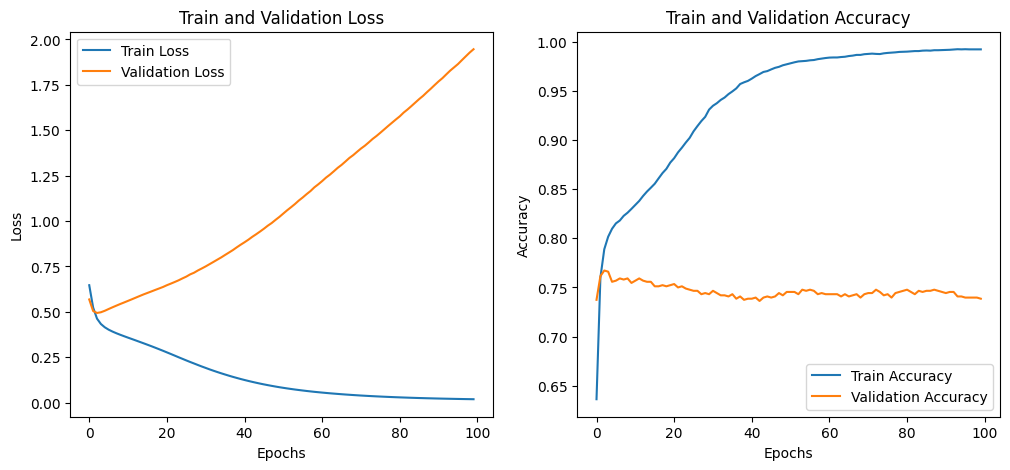

In [12]:
import matplotlib.pyplot as plt

# plt loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# plt accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.show()

En el grafo de arriba podemos observar que el Loss de Train disminuye gradualmente de 0.6+ a casi 0, mientras que el accuracy de Train aumenta de 0,6 a casi 1,0. Esto indica que el modelo aprende muy bien en el conjunto de entrenamiento y casi 'recuerda' los datos de entrenamiento.

El loss de Validation comienza en torno a 0.55 y aumenta gradualmente hasta como 2,0, mientras que el accuracy de Validation desciende de maximo de 0.75-0.80 a como 0.70. Esto significa que el rendimiento del modelo es muy bajo.

Esto significa que el rendimiento del modelo en el conjunto de validación sigue empeorando. La curva de entrenamiento y la de validación muestran tendencias opuestas

El conjunto de entrenamiento mejora y el conjunto de validación empeora, lo que es característico de un sobreajuste severo.

**Ejercicio 1b - Red multicapa**

In [13]:
from tensorflow.keras import layers, models

model_2 = Sequential()
model_2.add(layers.Dense(units=16, activation='relu', input_shape=(input_size,)))
# add 16 units
model_2.add(layers.Dense(units=16, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 16)             │        16,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,305 (63.69 KB)

 Trainable params: 16,305 (63.69 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history_2 = model_2.fit(x_training, y_training, epochs=100, batch_size=32, validation_data=(x_validation, y_validation), verbose=1)

Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5661 - loss: 0.6808 - val_accuracy: 0.7294 - val_loss: 0.5496
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7452 - loss: 0.5312 - val_accuracy: 0.7626 - val_loss: 0.4901
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7926 - loss: 0.4473 - val_accuracy: 0.7626 - val_loss: 0.5008
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8088 - loss: 0.4116 - val_accuracy: 0.7592 - val_loss: 0.5210
Epoch 5/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8221 - loss: 0.3846 - val_accuracy: 0.7638 - val_loss: 0.5441
Epoch 6/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8342 - loss: 0.3581 - val_accuracy: 0.7615 - val_loss: 0.5689
Epoch 7/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8509 - loss: 0.3304 - val_accuracy: 0.7580 - val_loss: 0.5974
Epoch 8/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8636 - loss: 0.3016 - val_accu

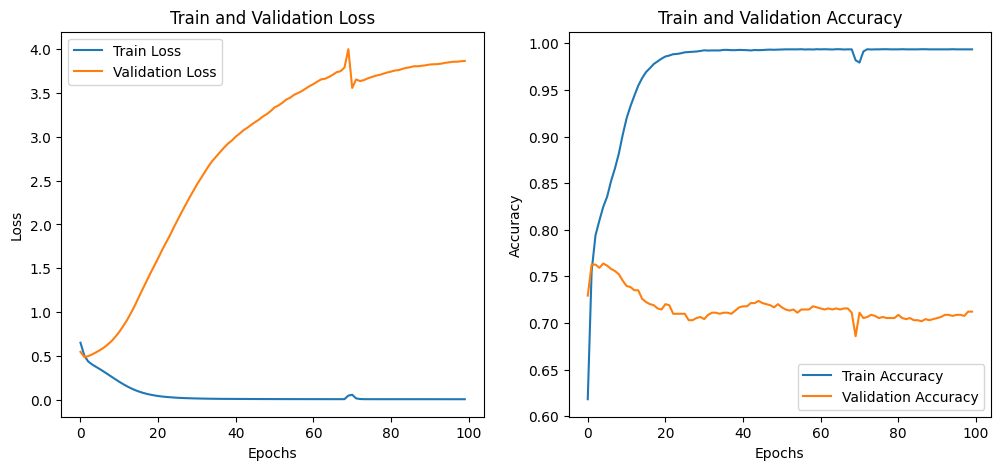

In [15]:
# plt loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# plt accuracy
plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.show()

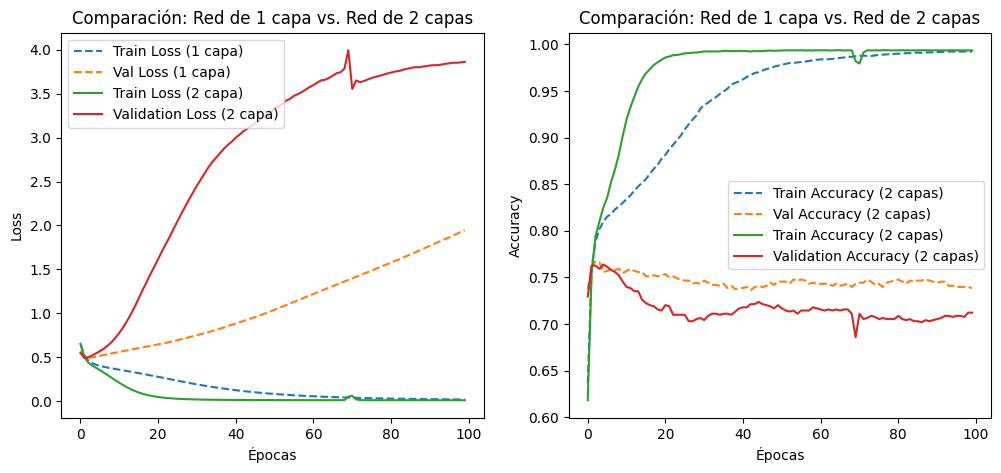

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (1 capa)', linestyle='--')
plt.plot(history.history['val_loss'], label='Val Loss (1 capa)', linestyle='--')
plt.plot(history_2.history['loss'], label='Train Loss (2 capa)')
plt.plot(history_2.history['val_loss'], label='Validation Loss (2 capa)')
plt.title('Comparación: Red de 1 capa vs. Red de 2 capas')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy (2 capas)', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Val Accuracy (2 capas)', linestyle='--')
plt.plot(history_2.history['accuracy'], label='Train Accuracy (2 capas)')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy (2 capas)')
plt.title('Comparación: Red de 1 capa vs. Red de 2 capas')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

En la gráfica de la izquierda, se ve que la red de 2 capas aprende el entrenamiento muy rápido y lleva la pérdida de entrenamiento casi a 0, pero su pérdida de validación sube más y acaba bastante por encima de la red de 1 capa, lo que indica un sobreajuste más pronunciado.

En la gráfica de la derecha, la red de 2 capas también alcanza rápidamente un accuracy cercano a 1.0 en entrenamiento, pero en validación la exactitud es menor y desciende con las épocas, mientras que la red de 1 capa mantiene un comportamiento más estable, aunque también sobreajusta.

**Ejercicio 1c - Evitando el sobreajuste: early stopping, weight regularization, dropout**

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

model_2_early_stopping = Sequential()
model_2_early_stopping.add(Dense(units=16, activation='relu', input_shape=(input_size,)))
model_2_early_stopping.add(Dense(units=16, activation='relu'))
model_2_early_stopping.add(Dense(units=1, activation='sigmoid'))

model_2_early_stopping.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_2_early_stopping = model_2_early_stopping.fit(x_training, y_training, epochs=100, batch_size=32,validation_data=(x_validation, y_validation), callbacks=[early_stopping], verbose=1)

Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5618 - loss: 0.6805 - val_accuracy: 0.7339 - val_loss: 0.5523
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7465 - loss: 0.5307 - val_accuracy: 0.7569 - val_loss: 0.4982
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7980 - loss: 0.4461 - val_accuracy: 0.7534 - val_loss: 0.5095
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8225 - loss: 0.4062 - val_accuracy: 0.7557 - val_loss: 0.5304
Epoch 5/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8376 - loss: 0.3725 - val_accuracy: 0.7511 - val_loss: 0.5600


## With Early Stopping vs. Without Early Stopping ##

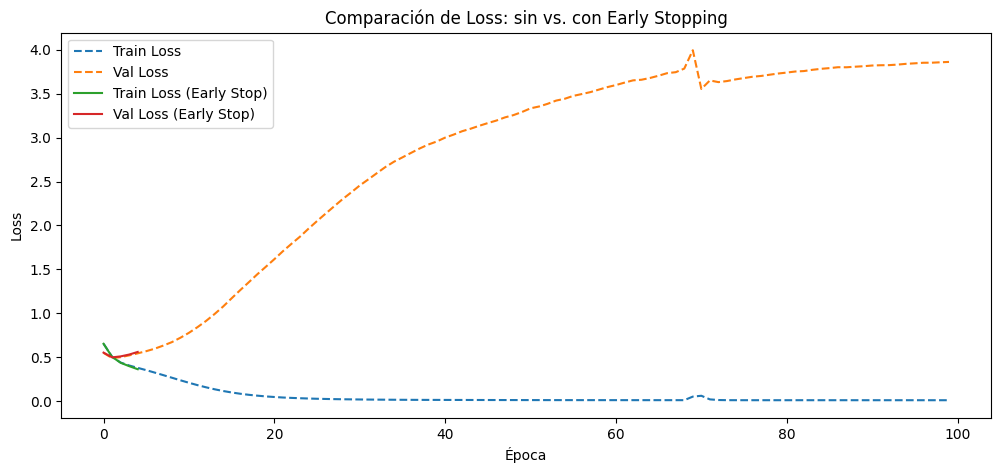

In [18]:
plt.figure(figsize=(12, 5))
# History 2 without early stopping
plt.plot(history_2.history['loss'], label='Train Loss', linestyle='--')
plt.plot(history_2.history['val_loss'], label='Val Loss', linestyle='--')
# History 2 with early stopping
plt.plot(history_2_early_stopping.history['loss'], label='Train Loss (Early Stop)')
plt.plot(history_2_early_stopping.history['val_loss'], label='Val Loss (Early Stop)')

plt.title('Comparación de Loss: sin vs. con Early Stopping')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

En la gráfica se ve que con Early Stopping, el entrenamiento se detiene en el epoch 5, entrenar antes de que el sobreajuste sea demasiado grande

In [19]:
from tensorflow.keras import regularizers

model_2_l2 = Sequential()
model_2_l2.add(Dense(units=16, activation='relu', input_shape=(input_size,), kernel_regularizer=regularizers.l2(0.01)))
model_2_l2.add(Dense(units=16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_2_l2.add(Dense(units=1, activation='sigmoid'))
model_2_l2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_2_l2 = model_2_l2.fit(x_training, y_training, batch_size=32, epochs=100, validation_data=(x_validation, y_validation), verbose=1)

Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5779 - loss: 0.9066 - val_accuracy: 0.7213 - val_loss: 0.6703
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7150 - loss: 0.6697 - val_accuracy: 0.7420 - val_loss: 0.6200
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7457 - loss: 0.6280 - val_accuracy: 0.7523 - val_loss: 0.6068
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7629 - loss: 0.6089 - val_accuracy: 0.7557 - val_loss: 0.5997
Epoch 5/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7692 - loss: 0.5961 - val_accuracy: 0.7626 - val_loss: 0.5950
Epoch 6/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7730 - loss: 0.5861 - val_accuracy: 0.7649 - val_loss: 0.5914
Epoch 7/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7777 - loss: 0.5777 - val_accuracy: 0.7603 - val_loss: 0.5888
Epoch 8/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7790 - loss: 0.5709 - val_accu

## With L2 vs. Without L2 ##

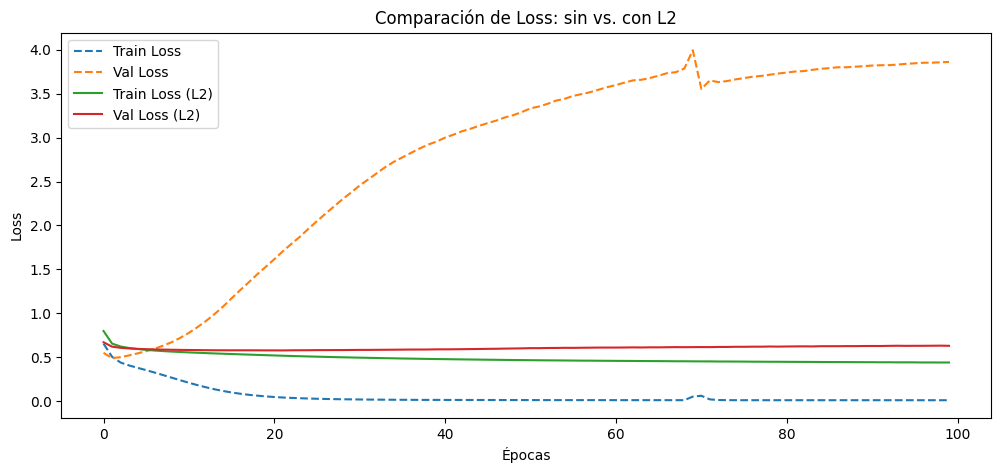

In [20]:
plt.figure(figsize=(12, 5))

plt.plot(history_2.history['loss'], label='Train Loss', linestyle='--')
plt.plot(history_2.history['val_loss'], label='Val Loss', linestyle='--')

plt.plot(history_2_l2.history['loss'], label='Train Loss (L2)')
plt.plot(history_2_l2.history['val_loss'], label='Val Loss (L2)')

plt.title('Comparación de Loss: sin vs. con L2')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()


Penaliza los pesos grandes durante el entrenamiento, elevando la pérdida de entrenamiento, pero controlando el crecimiento de la pérdida de validación. De esta forma se reduce el sobreajuste.

In [21]:
from tensorflow.keras.layers import Dropout

model_2_drop = Sequential()
model_2_drop.add(Dense(units=16, activation='relu', input_shape=(input_size,)))
model_2_drop.add(layers.Dropout(0.5))

model_2_drop.add(Dense(units=16, activation='relu'))
model_2_drop.add(layers.Dropout(0.5))

model_2_drop.add(Dense(units=1, activation='sigmoid'))

model_2_drop.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

history_2_drop = model_2_drop.fit(
    x_training, y_training,
    epochs=100,
    batch_size=32,
    validation_data=(x_validation, y_validation),
    verbose=1
)


Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5054 - loss: 0.6948 - val_accuracy: 0.5780 - val_loss: 0.6730
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5910 - loss: 0.6670 - val_accuracy: 0.7328 - val_loss: 0.5992
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6752 - loss: 0.6034 - val_accuracy: 0.7546 - val_loss: 0.5276
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7342 - loss: 0.5398 - val_accuracy: 0.7615 - val_loss: 0.5033
Epoch 5/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7689 - loss: 0.4950 - val_accuracy: 0.7649 - val_loss: 0.4974
Epoch 6/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7856 - loss: 0.4601 - val_accuracy: 0.7603 - val_loss: 0.5029
Epoch 7/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8043 - loss: 0.4323 - val_accuracy: 0.7592 - val_loss: 0.5112
Epoch 8/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8129 - loss: 0.4234 - val_accu

## With Dropout vs. Without Dropout ##

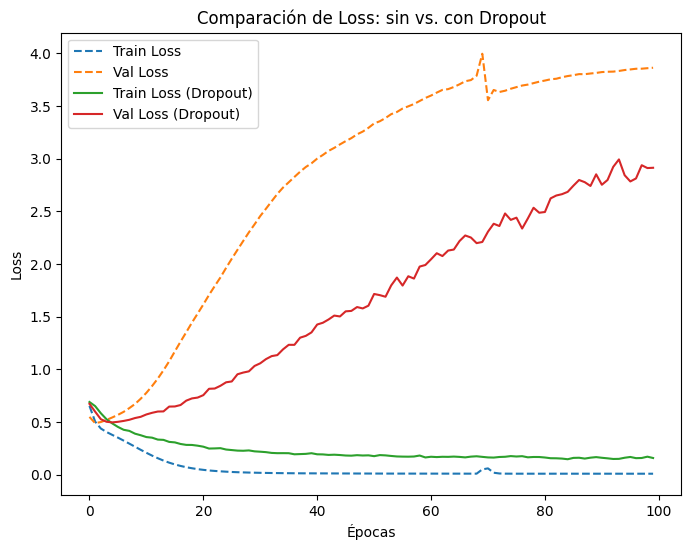

In [22]:
plt.figure(figsize=(8, 6))

plt.plot(history_2.history['loss'], label='Train Loss', linestyle='--')
plt.plot(history_2.history['val_loss'], label='Val Loss', linestyle='--')

plt.plot(history_2_drop.history['loss'], label='Train Loss (Dropout)')
plt.plot(history_2_drop.history['val_loss'], label='Val Loss (Dropout)')

plt.title('Comparación de Loss: sin vs. con Dropout')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()


la pérdida de entrenamiento (curvas roja y verde) no baje tan rápido, pero también mitiga el sobreajuste en la validación.

las tres maneras ayudan a mejorar la generalización del modelo: Early Stopping corta el entrenamiento a tiempo, la L2 limita el crecimiento de los pesos, y Dropout añade aleatoriedad para evitar la dependencia excesiva en ciertas neuronas.

**Ejercicio 1d - Evaluación de hiperparámetros mediante grid search**

In [23]:
def create_model(input_dim, learning_rate=1e-3, dropout_rate=0.0, l2_factor=1e-4):
    model = Sequential()

    #layer 1
    model.add(layers.Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(l2_factor), input_shape=(input_dim,)))
    model.add(layers.Dropout(dropout_rate))

    #layer 2
    model.add(layers.Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(l2_factor)))
    model.add(layers.Dropout(dropout_rate))

    #layer 3
    model.add(layers.Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(l2_factor)))
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(units=1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [24]:
learning_rates = [1e-4, 1e-3, 1e-2]
dropouts = [0.0, 0.2, 0.5]
l2_factors = [1e-4]

EPOCHS = 100
results = []

for lr in learning_rates:
    for do in dropouts:
        for l2_ in l2_factors:
            model = create_model(input_dim=input_size, learning_rate=lr, dropout_rate=do, l2_factor=l2_)
            best_test_acc = 0.0
            best_epoch = 0

            for epoch in range(1, EPOCHS + 1):
                history = model.fit(x_training, y_training, batch_size=32, epochs=1, verbose=0, validation_data=(x_validation, y_validation))
                test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    best_epoch = epoch

            results.append({
                'learning_rate': lr,
                'dropout': do,
                'l2_factor': l2_,
                'best_test_acc': best_test_acc,
                'best_epoch': best_epoch
            })

df_results = pd.DataFrame(results)
df_results

,learning_rate,dropout,l2_factor,best_test_acc,best_epoch
0,0.0001,0.0,0.0001,0.757825,96
1,0.0001,0.2,0.0001,0.768808,73
2,0.0001,0.5,0.0001,0.763317,19
3,0.0010,0.0,0.0001,0.752883,1
4,0.0010,0.2,0.0001,0.762768,11
5,0.0010,0.5,0.0001,0.772103,7
6,0.0100,0.0,0.0001,0.751785,1
7,0.0100,0.2,0.0001,0.744646,2
8,0.0100,0.5,0.0001,0.749588,2


In [25]:
df_results_sorted = df_results.sort_values(by='best_test_acc', ascending=False)
df_results_sorted

,learning_rate,dropout,l2_factor,best_test_acc,best_epoch
5,0.0010,0.5,0.0001,0.772103,7
1,0.0001,0.2,0.0001,0.768808,73
2,0.0001,0.5,0.0001,0.763317,19
4,0.0010,0.2,0.0001,0.762768,11
0,0.0001,0.0,0.0001,0.757825,96
3,0.0010,0.0,0.0001,0.752883,1
6,0.0100,0.0,0.0001,0.751785,1
8,0.0100,0.5,0.0001,0.749588,2
7,0.0100,0.2,0.0001,0.744646,2


# ***Ejercicio 2 - LSTMs***

# Preprocesado de datos - Tokenization y sequence padding

In [26]:
from tensorflow.keras import preprocessing

# Creamos un tokenier que considera las 1000 palabras más frecuentes en el corpus
max_words = 10000
tokenizer = preprocessing.text.Tokenizer(num_words=max_words)

# Construimos el índice (diccionario) de palabras a partir del conjunto de datos de entrenamiento
tokenizer.fit_on_texts(training_texts)
word_index = tokenizer.word_index

# Obtenemos los textos como secuencias de enteros
trainining_sequences = tokenizer.texts_to_sequences(training_texts)
validation_sequences = tokenizer.texts_to_sequences(validation_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Padding: convertimos las secuencias de enteros a un tensor 2D de forma (numero_secuencias, longitud_secuencia)
# Con ello igualamos la longitud de las secuencias de entrada
max_seq = 40
x_traininig = preprocessing.sequence.pad_sequences(trainining_sequences, maxlen=max_seq)
x_vadidation = preprocessing.sequence.pad_sequences(validation_sequences, maxlen=max_seq)
x_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_seq)

y_traininig = training_labels
y_validation = validation_labels
y_test = test_labels

print('Dimensiones del conjunto de entrenamiento: {}'.format(x_training.shape))
print('Dimensiones del conjunto de validación: {}'.format(x_validation.shape))
print('Dimensiones del conjunto de test: {}'.format(x_test.shape))

# Visualizamos un par de instancias de entrenamiento
print('\nTexto: {}\nVector padded: {}'.format(training_texts.iloc[0], x_training[0]))
print('\nTexto: {}\nVector padded: {}'.format(training_texts.iloc[1], x_training[1]))

Dimensiones del conjunto de entrenamiento: (6920, 1000)
Dimensiones del conjunto de validación: (872, 1000)
Dimensiones del conjunto de test: (1821, 40)

Texto: It is dark , brooding and slow , and takes its central idea way too seriously .
Vector padded: [0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

# Construcción de la red

In [27]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM

embedding_size = 128
lstm_hidden_size = 128

model = Sequential()

# Añadimos una capa de embeddings
# Usamos mask_zero=True para ignorar los token '0' en el padding
# Tras la capa de embeddings, las activaciones tienen la forma (batch_size, max_seq, embedding_size)
model.add(Embedding(max_words, embedding_size, mask_zero=True))

# Añadimos una capa LSTM
model.add(LSTM(lstm_hidden_size))

# Añadimos una capa de salida
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # probar optimizer='rmsprop' en RNN y LSTM
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Entrenamos la red durante 20 épocas y con batches de tamaño 128
history_lstm = model.fit(x_training, y_training, epochs=20, batch_size=128, validation_data=(x_validation, y_validation), verbose=1)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5135 - loss: 0.6931 - val_accuracy: 0.5092 - val_loss: 0.6933
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.5200 - loss: 0.6924 - val_accuracy: 0.5092 - val_loss: 0.6933
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.5200 - loss: 0.6923 - val_accuracy: 0.5092 - val_loss: 0.6933
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.5200 - loss: 0.6923 - val_accuracy: 0.5092 - val_loss: 0.6934
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.5200 - loss: 0.6922 - val_accuracy: 0.5092 - val_loss: 0.6934
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.5184 - loss: 0.6922 - val_accuracy: 0.5103 - val_loss: 0.6935
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.5167 - loss: 0.6922 - val_accuracy: 0.5092 - val_loss: 0.6935
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.5167 - loss: 0.6923 - val_accuracy: 0.5103 - va

**Ejercicio 2a - LSTM de una capa**

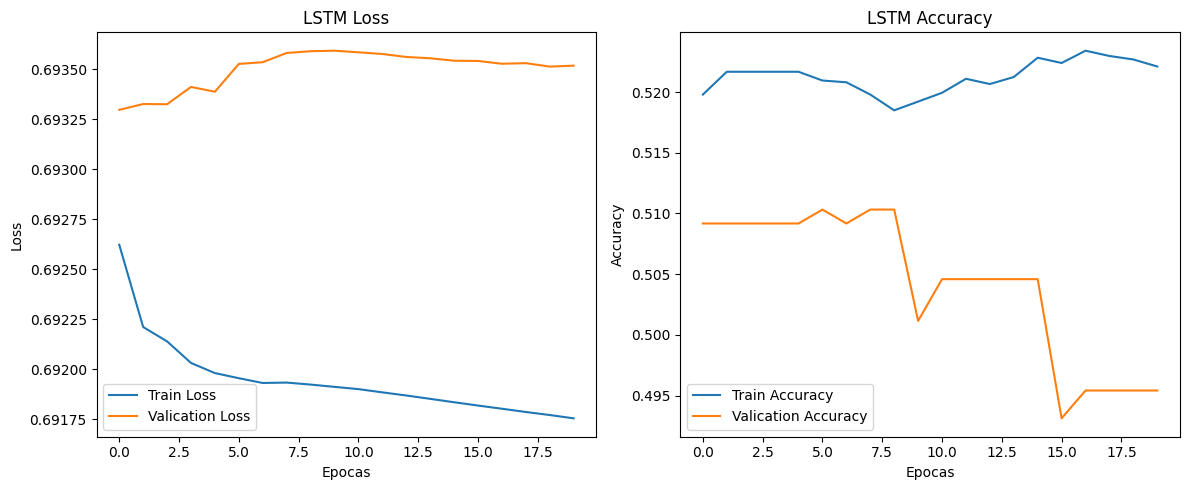

In [29]:
plt.figure(figsize=(12,5))
# loss
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Valication Loss')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.title('LSTM Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Valication Accuracy')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.title('LSTM Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


La pérdida de entrenamiento (línea azul) baja de 0.69260 a 0.69175, indicando que el modelo LSTM está aprendiendo patrones en los datos de entrenamiento.

La pérdida de validación (línea naranja) se mantiene en torno a 0.69325-0.69350. Esto sugiere que el modelo no está mejorando mucho en su generalización.

La exactitud de entrenamiento se mantiene en torno a 0.52–0.53, indicando una ligera mejora pero no muy marcada.

La exactitud de validación oscila entre 0.50 y 0.51, llegando incluso a 0.495 en algunos puntos, reflejando inestabilidad en el rendimiento sobre el conjunto de validación.

| Tipos de Red      | Tiempo |
| ----------- | ----------- |
| Redes neuronales feedforward      | 11 mins 26s       |
| Redes neuronales recurrentes   | 21 mins 18s        |

las redes neuronales recurrentes tardan más en entrenarse (21 min 18 s) en comparación con las redes neuronales feedforward (11 min 26 s).

Esto se debe a que las RNN/LSTM procesan los datos secuencialmente y mantienen un estado interno que se actualiza paso a paso, lo cual conlleva un mayor costo computacional.

En cambio, las FFN tienen un flujo de datos más directo y menos dependencias, resultando en un entrenamiento más rápido.

**Ejercicio 2b - Early stopping**

In [30]:
model_lstm_early_stopping = Sequential()
model_lstm_early_stopping.add(Embedding(input_dim=max_words, output_dim=64, input_length=40))
model_lstm_early_stopping.add(LSTM(64))
model_lstm_early_stopping.add(Dense(1, activation='sigmoid'))

model_lstm_early_stopping.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_lstm_early_stopping.summary()

c:\Users\Xudon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
history_lstm_stop = model_lstm_early_stopping.fit(x_traininig, y_traininig, epochs=100, batch_size=32, validation_data=(x_vadidation, y_validation), callbacks=[early_stop], verbose=1)

Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5736 - loss: 0.6615 - val_accuracy: 0.7741 - val_loss: 0.4815
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8450 - loss: 0.3621 - val_accuracy: 0.7867 - val_loss: 0.4849
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9323 - loss: 0.1865 - val_accuracy: 0.7752 - val_loss: 0.6914
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9653 - loss: 0.0978 - val_accuracy: 0.7787 - val_loss: 1.0711


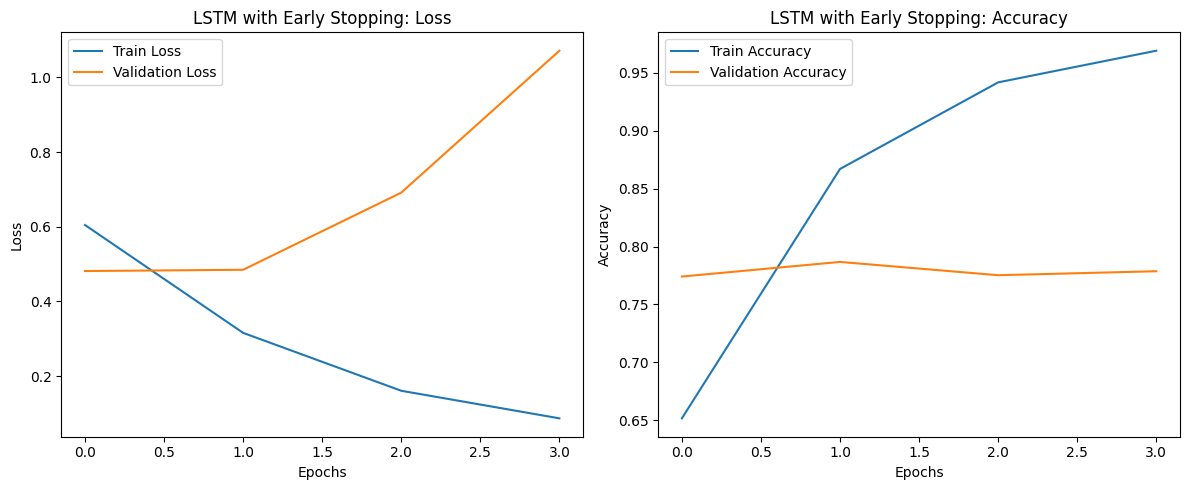

In [32]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_lstm_stop.history['loss'], label='Train Loss')
plt.plot(history_lstm_stop.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM with Early Stopping: Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_lstm_stop.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm_stop.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM with Early Stopping: Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


El modelo se sobreajusta claramente: mejora mucho en entrenamiento pero empeora en validación.

**Ejercicio 2c - Tamaño de embeddings y número de unidades LSTM**



In [33]:
embedding_dims = [32, 64, 128]
lstm_units_list = [32, 64, 128]

results = []

for emb_dim in embedding_dims:
    for lstm_units in lstm_units_list:
        model = Sequential()
        model.add(Embedding(input_dim=max_words,
                            output_dim=emb_dim,
                            input_length=max_seq))
        model.add(LSTM(lstm_units))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        early_stop = EarlyStopping(monitor='val_loss',
                                   patience=3,
                                   restore_best_weights=True)

        history_temp = model.fit(
            x_traininig, y_traininig,
            epochs=10,
            batch_size=32,
            validation_data=(x_validation, y_validation),
            callbacks=[early_stop],
            verbose=1
        )

        val_loss = history_temp.history['val_loss'][-1]
        val_acc = history_temp.history['val_accuracy'][-1]

        results.append({
            'embedding_dim': emb_dim,
            'lstm_units': lstm_units,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

import pandas as pd
df_results = pd.DataFrame(results)
df_results.sort_values(by='val_acc', ascending=False, inplace=True)
df_results

Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5618 - loss: 0.6730 - val_accuracy: 0.4908 - val_loss: 0.7261
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8365 - loss: 0.3932 - val_accuracy: 0.4908 - val_loss: 0.8074
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9207 - loss: 0.2156 - val_accuracy: 0.4908 - val_loss: 0.8694
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9562 - loss: 0.1280 - val_accuracy: 0.4908 - val_loss: 0.9665
Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5585 - loss: 0.6813 - val_accuracy: 0.4908 - val_loss: 1.3622
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7668 - loss: 0.4997 - val_accuracy: 0.4908 - val_loss: 1.6436
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8930 - loss: 0.2659 - val_accuracy: 0.4908 - val_loss: 1.5365
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9468 - loss: 0.1613 - val_accu

,embedding_dim,lstm_units,val_loss,val_acc
0,32,32,0.966470,0.490826
1,32,64,1.596710,0.490826
2,32,128,1.504217,0.490826
3,64,32,0.836925,0.490826
4,64,64,0.966762,0.490826
5,64,128,0.781192,0.490826
6,128,32,0.766640,0.490826
7,128,64,0.817587,0.490826
8,128,128,0.849991,0.490826


La exactitud de validación (val_acc) se mantiene alrededor de 0.490826 en todos los casos, cerca del azar en una tarea binaria.

La pérdida de validación (val_loss) oscila entre ~0.78 y ~1.15, sin una mejora consistente.

El modelo no está aprendiendo adecuadamente; podría requerir más épocas de entrenamiento, un ajuste de la tasa de aprendizaje o una verificación del proceso de preprocesamiento de datos.



# ***Ejercicio 3 - LSTMs avanzadas***

**Ejercicio 3a - Stacked LSTMs**

In [34]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

embedding_size = 128
lstm_hidden_size = 64

max_words = 10000
mode_stacked = Sequential()

mode_stacked.add(Embedding(max_words, embedding_size, mask_zero=False))

mode_stacked.add(LSTM(lstm_hidden_size, return_sequences=True))

mode_stacked.add(LSTM(lstm_hidden_size))

mode_stacked.add(Dense(1, activation='sigmoid'))

mode_stacked.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
mode_stacked.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
stacked_lstm = mode_stacked.fit(x_training, y_training, epochs=20, batch_size=128, validation_data=(x_validation, y_validation), verbose=1)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.5139 - loss: 0.6930 - val_accuracy: 0.5092 - val_loss: 0.6934
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 236s 4s/step - accuracy: 0.5200 - loss: 0.6925 - val_accuracy: 0.5092 - val_loss: 0.6935
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 239s 4s/step - accuracy: 0.5200 - loss: 0.6925 - val_accuracy: 0.5092 - val_loss: 0.6935
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.5200 - loss: 0.6925 - val_accuracy: 0.5092 - val_loss: 0.6935
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.5200 - loss: 0.6925 - val_accuracy: 0.5092 - val_loss: 0.6934
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - accuracy: 0.5200 - loss: 0.6925 - val_accuracy: 0.5092 - val_loss: 0.6934
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.5200 - loss: 0.6925 - val_accuracy: 0.5092 - val_loss: 0.6934
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - accuracy: 0.5200 - loss: 0.6925 - val_accuracy: 0.5092 - v

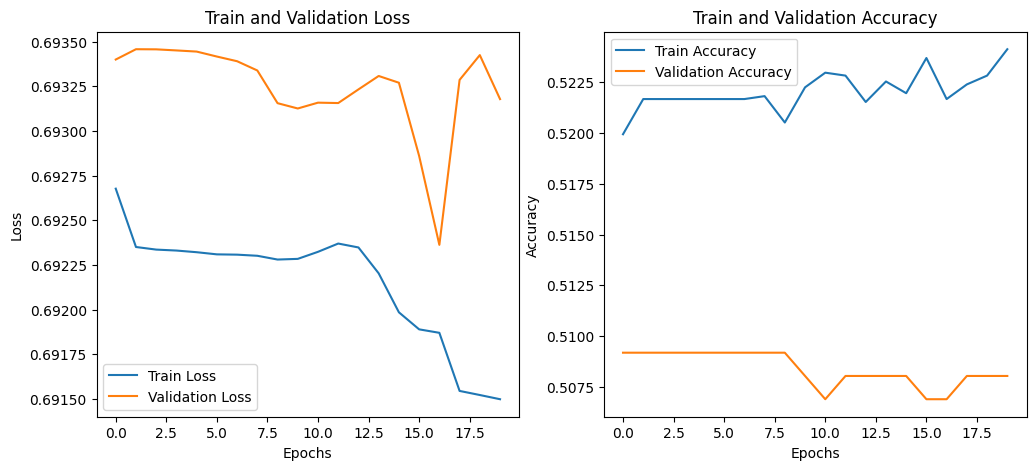

In [36]:
import matplotlib.pyplot as plt

# plt loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(stacked_lstm.history['loss'], label='Train Loss')
plt.plot(stacked_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# plt accuracy
plt.subplot(1, 2, 2)
plt.plot(stacked_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(stacked_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.show()

**Ejercicio 3b - Bidirectional LSTMs**

In [1]:
import tensorflow as tf
print("Is built with CUDA:", tf.test.is_built_with_cuda())

Is built with CUDA: False


In [ ]:
from tensorflow.keras.layers import Bidirectional



max_words = 10000
embedding_size = 128
max_lengh = 40

model_bidirectional = Sequential()
model_bidirectional.add(Embedding(max_words, embedding_size, input_length=max_lengh))
model_bidirectional.add(Bidirectional(LSTM(128)))

model_bidirectional.add(Dense(1, activation='sigmoid'))

model_bidirectional.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_bidirectional.summary()

c:\Users\Xudon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
history_lstm_bidirectional = model_bidirectional.fit(x_training, y_training, epochs=20, batch_size=128, validation_data=(x_validation, y_validation), verbose=2)

Epoch 1/20
55/55 - 271s - 5s/step - accuracy: 0.5228 - loss: 0.6918 - val_accuracy: 0.5424 - val_loss: 0.6863
Epoch 2/20
55/55 - 308s - 6s/step - accuracy: 0.5332 - loss: 0.6906 - val_accuracy: 0.5642 - val_loss: 0.6842
Epoch 3/20


KeyboardInterrupt: 

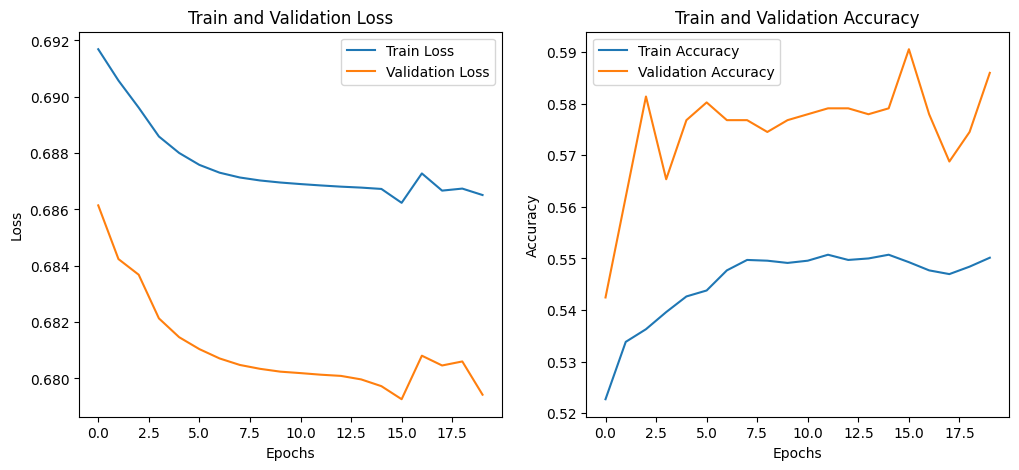

In [ ]:
import matplotlib.pyplot as plt

# plt loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm_bidirectional.history['loss'], label='Train Loss')
plt.plot(history_lstm_bidirectional.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# plt accuracy
plt.subplot(1, 2, 2)
plt.plot(history_lstm_bidirectional.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm_bidirectional.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.show()

# **Ejercicio 4 - Embeddings pre-entrenados: Glove**

# Carga de los embeddings

In [ ]:
import bz2
embsfile = bz2.open(data_folder + 'glove.6B.50d.txt.bz2')

embeddings_index = {}
for line in embsfile:
    line = line.decode('utf-8')
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

print("Found", len(embeddings_index), "word vectors.")

Found 400000 word vectors.


**Ejecicio 4a - Inicialización de la red con embeddings Glove**

In [ ]:
embedding_size = 50
vocab_size = len(words_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_size))

for word, i in words_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential

model_embedding = Sequential()
model_embedding.add(Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=max_lengh, trainable=False))
#model_embedding.layers[0].trainable = False

model_embedding.add(LSTM(64))
model_embedding.add(Dense(1, activation='sigmoid'))


model_embedding.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_embedding.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │         692,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 692,000 (2.64 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 692,000 (2.64 MB)

In [ ]:
history_pretrained = model_embedding.fit(x_training, y_training, epochs=20, batch_size=128, validation_data=(x_validation, y_validation), verbose=1)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5171 - loss: 0.6927 - val_accuracy: 0.5080 - val_loss: 0.6937
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5202 - loss: 0.6925 - val_accuracy: 0.5046 - val_loss: 0.6941
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5179 - loss: 0.6927 - val_accuracy: 0.5046 - val_loss: 0.6941
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5183 - loss: 0.6928 - val_accuracy: 0.5046 - val_loss: 0.6940
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5200 - loss: 0.6929 - val_accuracy: 0.5046 - val_loss: 0.6939
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5198 - loss: 0.6929 - val_accuracy: 0.5080 - val_loss: 0.6937
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5204 - loss: 0.6929 - val_accuracy: 0.5080 - val_loss: 0.6935
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5199 - loss: 0.6928 - val_accuracy: 0.5080 - v

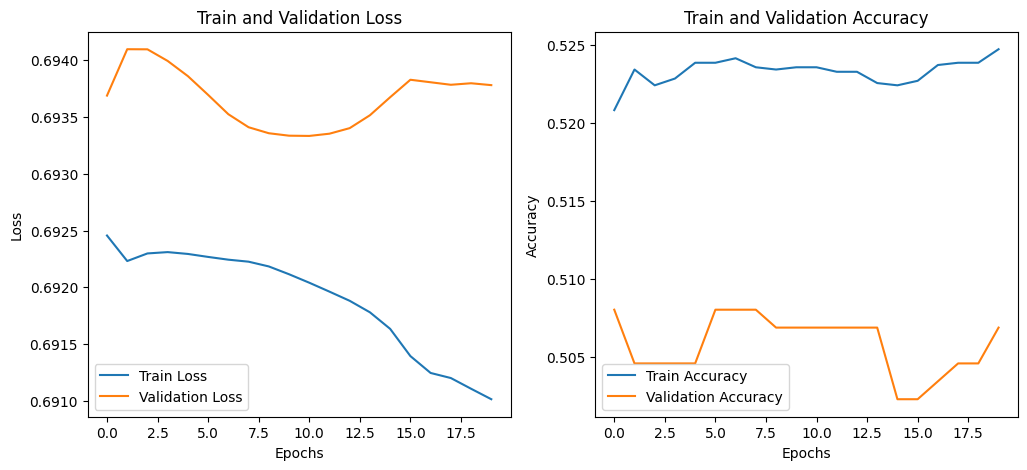

In [ ]:
import matplotlib.pyplot as plt

# plt loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_pretrained.history['loss'], label='Train Loss')
plt.plot(history_pretrained.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# plt accuracy
plt.subplot(1, 2, 2)
plt.plot(history_pretrained.history['accuracy'], label='Train Accuracy')
plt.plot(history_pretrained.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.show()

**Ejercicio 4b - Evitando el overfitting**

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

model_embedding_dropout = Sequential()
model_embedding_dropout.add(Embedding(vocab_size, embedding_size,
                                        weights=[embedding_matrix],
                                        input_length=max_lengh,
                                        trainable=False))

model_embedding_dropout.add(Dropout(0.5))


model_embedding_dropout.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))

model_embedding_dropout.add(Dense(1, activation='sigmoid'))

model_embedding_dropout.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_embedding_dropout.summary()


history_pretrained_dropout = model_embedding_dropout.fit(
    x_training, y_training,
    epochs=20,
    batch_size=128,
    validation_data=(x_validation, y_validation),
    verbose=1
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │         692,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 692,000 (2.64 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 692,000 (2.64 MB)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.5212 - loss: 0.6925 - val_accuracy: 0.5092 - val_loss: 0.6934
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.5209 - loss: 0.6922 - val_accuracy: 0.5046 - val_loss: 0.6932
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.5203 - loss: 0.6925 - val_accuracy: 0.5080 - val_loss: 0.6935
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.5197 - loss: 0.6926 - val_accuracy: 0.5069 - val_loss: 0.6935
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.5192 - loss: 0.6925 - val_accuracy: 0.5069 - val_loss: 0.6936
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.5209 - loss: 0.6922 - val_accuracy: 0.5080 - val_loss: 0.6935
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.5196 - loss: 0.6925 - val_accuracy: 0.5080 - val_loss: 0.6937
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.5218 - loss: 0.6922 - val_accuracy: 0.5080 - v

In [ ]:
import matplotlib.pyplot as plt

# plt loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_pretrained_dropout.history['loss'], label='Train Loss')
plt.plot(history_pretrained_dropout.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# plt accuracy
plt.subplot(1, 2, 2)
plt.plot(history_pretrained_dropout.history['accuracy'], label='Train Accuracy')
plt.plot(history_pretrained_dropout.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.show()